In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import copy
import random
import json
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
#sns.set_theme(style="ticks", palette="pastel")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [4]:
from resources.helper import PeakData, Isotopes
known_cys_fnam = 'resources/known_cys_labeled.tab'
known_gln_fnam = 'resources/known_gln_labeled.tab'
# blacklist_fnam = 'resources/blacklist.tab'
blacklist_fnam = 'resources/blacklist-GSH-artifacts.tab'

# Read isotope information into an object:
IUPAC_atomic_masses = 'resources/IUPAC-atomic-masses.csv'
IUPAC_atomic_abundances = 'resources/IUPAC-atomic-abundances.html'
isotope_obj = Isotopes(IUPAC_atomic_masses, IUPAC_atomic_abundances)

# Adducts:
adducts_fnam = 'resources/adducts.tab'

## Define default parameters for peak filtering and peak pair finding

In [5]:
params = {
    ### Specify the formula for the isotopes in the labels used ###
    'labels': {
        'cys': '[13]C3 [15]N',
        'gly': '[13]C2',
        'gln': '[13]C5'
    },
    # End of isotope specification ################################

    ### Peak filter parameters ###
    'min_area': 25000,        # minimum peak area for at least one sample
    'min_area_label': 15000,  # minimum peak area for at least one labelled sample
    'min_MW': 120,            # minimum molecular weight of a compound (120 is one Da below Cysteine)
    'min_fold_blank': 4,      # minimum sample to blank peak area ratio
                              # i.e. max(sample)/max(blank) > min_fold_blank

    # Peak filter: peak merging #
    # Merge peaks within a ppm mass distance AND within
    # a retention time difference OR a retention time difference x2
    # AND over a minimum peak area correlation coefficient
    'merge_ppm_tol': 50,      # maximum mass distance (in ppm) between peaks to merge
    'merge_RT_tol': 0.1,      # maximum retention time difference between peaks to merge
    'merge_corr_tol':0.9,     # minimum peak area correlation coefficient
    # End of peak filter #########
    
    ### Peak pair finding ###
    'pair_ppm_tol': 10,            # maximum mass distance (in ppm) of expected mass shift between pairs
    'pair_RT_tol': 0.25,           # maximum retention time difference between pairs
    'pair_min_area': 1,            # minimum number of sample that pass the area ratio criterium

    # Range, or list of ranges, of labelled to unlabelled peak area ratios
    # within the accepted cutoff (ratio = labelled / sum(labelled, unlabelled))
    # These ratios are adjusted on an experiment-to-experiment basis (see below examples).
    'area_ratio_cutoff': {
        'cys': ((0.2, 0.28),
                (0.34, 0.42)),  # GSSG theoretical parent/(parent+heavy) is 0.25 with 50/50 labelled
        'gly': ((0.08, 0.24),),
        'gln': ((0.18, 0.6),),
    },
    # End of pair finding ###
    
    ### Peak pair filter parameters ###
    # Pair filter: adduct flagging #
    # Flag an adduct if it is within a ppm mass distance
    # and within a retention time difference
    # and has smaller total peak area than its parent ion
    'adduct_ppm_tol': 200,     # maximum mass distance (in ppm) to call adduct
    'adduct_RT_tol': 0.8,      # maximum retention time difference to call adduct

    # Pair filter: isotope flagging #
    # Flag an isotope if it is within a ppm mass distance
    # and within a retention time difference
    # and has a minimum peak area correlation coefficient
    # and has smaller total peak area than its parent ion
    'isotope_ppm_tol': 200,     # maximum mass distance (in ppm) to call isotope
    'isotope_RT_tol': 0.4,      # maximum retention time difference to call isotope
    'isotope_corr_tol':0.7,     # minimum peak area correlation coefficient to call isotope
    # End of peak pair filter #########

}

# Calculate the mass shift for each label:
params['MW_shift'] = dict()
for label in params['labels']:
    params['MW_shift'][label] = isotope_obj.isotopes2mass_shift(params['labels'][label])
print('Calculated mass shift for entered labels:')
pp.pprint(params['MW_shift'])

Calculated mass shift for entered labels:
{'cys': 4.007099400040005,
 'gln': 5.016774176699997,
 'gly': 2.0067096706799994}


## Cysteine tracing on NRF2 on/off cancer cell lines

Anna.

Put description here.


In [6]:
# Excel data filenames:
datafile_pos = 'projects/bile-duct-cells_cys-tracing/pos/bile-duct-cells_cys-tracing_pos.xlsx'
datafile_neg = 'projects/bile-duct-cells_cys-tracing/neg/bile-duct-cells_cys-tracing_neg.xlsx'

# Input information:
input_desc_fnam = 'projects/bile-duct-cells_cys-tracing/bile-duct-cells_cys-tracing.json'
# Since comments are not allowed in JSON format
# Use the eval function to turn this pseudo JSON into a dictionary:
input_desc = eval(open(input_desc_fnam, 'r').read())

# Read the data:
peak_obj = PeakData('bile-duct-cells_cys-tracing', input_desc, params)

# Read peaks:
peak_obj.read_peaks(datafile_pos, 'pos')
peak_obj.read_peaks(datafile_neg, 'neg')

# Annotate known peaks:
peak_obj.annotate_known_peaks(known_cys_fnam, isotope_obj.formula2mass)

Running peak filtering for polarity: pos
Filtered 20922 peaks out based on.
Minimum peak area: 17531
Minimum molecular weight: 1307
Minimum fold over blank: 1506
Merged closely related peaks: 578
5208 peaks left.

Running peak filtering for polarity: neg
Filtered 12797 peaks out based on.
Minimum peak area: 10971
Minimum molecular weight: 676
Minimum fold over blank: 803
Merged closely related peaks: 347
3350 peaks left.



### Adjust parameters for peak pair finding

In [7]:
# Find labelling ratio for known cysteine labelled
# compounds in positive polarity:
peak_obj.pick_ratio(known_cys_fnam, 'pos', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),R5P Cys (m),R5P Cys (m+4),G3P Cys (m),G3P Cys (m+4),DHAP Cys (m),DHAP Cys (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4),GSH conjugate EC = C4H10NO (m),GSH conjugate EC = C4H10NO (m+4)
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.0,45.0
mean,0.712245,0.287755,0.241345,0.758655,0.672476,0.327524,0.672476,0.327524,0.730420,0.269580,0.5,0.5
std,0.034853,0.034853,0.312809,0.312809,0.067095,0.067095,0.067095,0.067095,0.044956,0.044956,0.0,0.0
min,0.653103,0.219940,0.004959,0.053652,0.479499,0.182168,0.479499,0.182168,0.662294,0.166414,0.5,0.5
25%,0.680715,0.259216,0.028014,0.693386,0.655722,0.294704,0.655722,0.294704,0.692161,0.241731,0.5,0.5
50%,0.710955,0.289045,0.065481,0.934519,0.680577,0.319423,0.680577,0.319423,0.728005,0.271995,0.5,0.5
75%,0.740784,0.319285,0.306614,0.971986,0.705296,0.344278,0.705296,0.344278,0.758269,0.307839,0.5,0.5
max,0.780060,0.346897,0.946348,0.995041,0.817832,0.520501,0.817832,0.520501,0.833586,0.337706,0.5,0.5


In [8]:
# Find labelling ratio for known cysteine labelled
# compounds in negative polarity:
peak_obj.pick_ratio(known_cys_fnam, 'neg', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),GSSG (m),GSSG (m+4),S-Lactoylglutathione (m),S-Lactoylglutathione (m+4),G3P Cys (m),G3P Cys (m+4),DHAP Cys (m),DHAP Cys (m+4),Glutamylcysteine (m),Glutamylcysteine (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4)
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,0.811704,0.188296,0.601234,0.398766,0.724710,0.275290,0.595271,0.404729,0.595271,0.404729,0.691954,0.308046,0.736890,0.263110
std,0.040624,0.040624,0.091994,0.091994,0.147137,0.147137,0.179007,0.179007,0.179007,0.179007,0.080559,0.080559,0.055895,0.055895
min,0.695934,0.112465,0.421315,0.141711,0.367926,0.073933,0.135119,0.039910,0.135119,0.039910,0.545065,0.174530,0.622300,0.170606
25%,0.794570,0.159100,0.541626,0.365109,0.655503,0.171553,0.547555,0.307316,0.547555,0.307316,0.648749,0.256964,0.686496,0.227070
50%,0.820300,0.179700,0.586749,0.413251,0.780642,0.219358,0.644210,0.355790,0.644210,0.355790,0.710486,0.289514,0.743820,0.256180
75%,0.840900,0.205430,0.634891,0.458374,0.828447,0.344497,0.692684,0.452445,0.692684,0.452445,0.743036,0.351251,0.772930,0.313504
max,0.887535,0.304066,0.858289,0.578685,0.926067,0.632074,0.960090,0.864881,0.960090,0.864881,0.825470,0.454935,0.829394,0.377700


In [9]:
# Based on above analysis the cutoff is chosen:
peak_obj.params['area_ratio_cutoff']['cys'] = ((0.05, 0.90),)

# RT and MW tolerances are also adjusted:
peak_obj.params['pair_ppm_tol'] = 5
peak_obj.params['pair_RT_tol'] = 0.25

### Search for peak pairs and flag isotopes, adducts etc

In [10]:
# Find pairs:
peak_obj.find_pairs('pos')
peak_obj.find_pairs('neg')

In [11]:
# Flag inferred adducts and blacklisted compounds
# in the peak pairs:
peak_obj.flag_blacklist(blacklist_fnam, polarity='both')
peak_obj.flag_adducts(adducts_fnam, polarity='both')

In [12]:
# Generate isotopic mass shift combinations:
isotope_set = isotope_obj.find_iso_set(min_abs=1e-6)
pp.pprint(isotope_set)

{('[13]C',): {'abundance': 0.010599999999999998,
              'mass_shift': 1.0033548353399997},
 ('[13]C', '[13]C'): {'abundance': 0.00011235999999999996,
                      'mass_shift': 2.0067096706799994},
 ('[13]C', '[13]C', '[13]C'): {'abundance': 1.1910159999999995e-06,
                               'mass_shift': 3.010064506020001},
 ('[13]C', '[13]C', '[34]S'): {'abundance': 4.9045139999999985e-06,
                               'mass_shift': 4.002505508140004},
 ('[13]C', '[15]N'): {'abundance': 4.022699999999999e-05,
                      'mass_shift': 2.0003897293599984},
 ('[13]C', '[15]N', '[34]S'): {'abundance': 1.7559085499999997e-06,
                               'mass_shift': 3.996185566820003},
 ('[13]C', '[17]O'): {'abundance': 4.065099999999999e-06,
                      'mass_shift': 2.00757197203},
 ('[13]C', '[18]O'): {'abundance': 2.1676999999999996e-05,
                      'mass_shift': 3.007599828220002},
 ('[13]C', '[2]H'): {'abundance': 1.53699999999

In [13]:
# Flag isotopes in the peak pairs:
peak_obj.flag_isotopes(isotope_set, polarity='both')

In [14]:
# Write results as Excel files:
peak_obj.write_pairs('projects/bile-duct-cells_cys-tracing/pos/bile-duct-cells_cys-tracing_pairs_pos', 'pos')
peak_obj.write_pairs('projects/bile-duct-cells_cys-tracing/neg/bile-duct-cells_cys-tracing_pairs_neg', 'neg')

### Processing the results

At this point, all the results have been written to Excel files which provide an interface to further processing/filtering/plotting.

In the following, I will show another way of processing the results and show some of the findings that can be extracted from the data.

In [15]:
# Extract sample information from the input description JSON
# stored in the "group" tag:
name2info = {desc['name']: desc for desc in input_desc.values() if desc['type'] != 'blank'}
sample_info_df = pd.DataFrame.from_dict(name2info, orient='index')
sample_info_df[['Cell_line','Genotype']] = sample_info_df.group.str.split(', ', expand=True)
sample_info_df.head(4)

,name,order,type,label,group,Cell_line,Genotype
CCLP_1,CCLP_1,19,sample,cys,"CCLP, bile-duct-NRF2-off",CCLP,bile-duct-NRF2-off
CCLP_2,CCLP_2,20,sample,cys,"CCLP, bile-duct-NRF2-off",CCLP,bile-duct-NRF2-off
CCLP_3,CCLP_3,21,sample,cys,"CCLP, bile-duct-NRF2-off",CCLP,bile-duct-NRF2-off
SSP25_1,SSP25_1,7,sample,cys,"SSP25, bile-duct-NRF2-on",SSP25,bile-duct-NRF2-on


In [16]:
# We start in positive polarity by grabbing the peak pairs from cystine tracing:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
df_pos.head(4)

,pair_id,MW_parent,RT_parent,MW_heavy,RT_heavy,polarity,label,name,RT_diff,MW_ppm_diff,Isotopes,Adducts,Blacklist,known_anno,KKU100_1,KKU100_2,KKU100_3,SNU308_1,SNU308_2,SNU308_3,SSP25_1,SSP25_2,SSP25_3,TFK_1,TFK_2,...,NRF2-const_dox_3,NRF2-const_vec_1,NRF2-const_vec_2,NRF2-const_vec_3,SSP25_13C-Glc_0m_1,SSP25_13C-Glc_0m_2,SSP25_13C-Glc_0m_3,SSP25_13C-Glc_5m_1,SSP25_13C-Glc_5m_2,SSP25_13C-Glc_5m_3,SSP25_13C-Glc_30m_1,SSP25_13C-Glc_30m_2,SSP25_13C-Glc_30m_3,SSP25_13C-Glc_2h_1,SSP25_13C-Glc_2h_2,SSP25_13C-Glc_2h_3,SSP25_13C-Glc_4h_1,SSP25_13C-Glc_4h_2,SSP25_13C-Glc_4h_3,SSP25_13C-Glc_6h_1,SSP25_13C-Glc_6h_2,SSP25_13C-Glc_6h_3,SSP25_13C-Glc_24h_1,SSP25_13C-Glc_24h_2,SSP25_13C-Glc_24h_3
0,"((121.01976, 8.621), (125.02687, 8.633), pos, ...",121.01976,8.621,125.02687,8.633,pos,cys,Cysteine,0.012,0.087589,None,None,None,Cysteine,129652.943017,150799.175331,135528.630211,29766.250715,25256.07377,25367.033865,278065.25709,210798.963128,316758.500464,149328.054286,142850.259678,...,1152.761196,859.86505,1001.264726,1037.514956,4679.127694,4237.377244,4572.312456,4672.473942,3929.169328,4480.713515,3439.498559,4382.803996,4108.664101,4321.545434,4448.406256,4119.554183,9103.855545,4633.668788,13412.099429,3849.168195,9214.667453,7749.688506,4659.700367,4272.51132,4882.654187
1,"((128.0586, 9.649), (132.06581, 9.529), pos, cys)",128.0586,9.649,132.06581,9.529,pos,cys,Dihydrothymine,0.12,0.863667,None,None,None,None,751362.932531,973764.211012,1046826.157455,6201598.669561,6144751.362036,6617526.512526,919201.448967,904171.961034,1117519.487083,14020504.225715,12975440.768751,...,15777168.529141,18180290.469287,15593998.961395,17140526.804338,3771719.782499,4585967.032172,4368104.90255,3649274.285272,4313054.801415,3151086.821811,1927095.454565,2602486.297758,2515107.368433,2213884.75987,2230409.159247,2308190.691698,1677700.087804,1594373.459464,2262711.415184,1544902.556849,1989314.64139,1893996.397133,5378315.284036,5372202.58431,5049059.602231
2,"((131.09734, 9.571), (135.10468, 9.581), pos, ...",131.09734,9.571,135.10468,9.581,pos,cys,NaN,0.01,1.835277,None,None,None,None,311.139163,311.310607,351.061968,5071.062297,5412.4926,6389.405354,823.456589,834.012352,986.458864,2794.236986,6076.555451,...,1928.001071,1634.849897,1595.510512,1688.128497,1033.648099,989.832003,1051.141878,914.898695,1958.323736,932.401288,641.749373,734.479005,728.855673,1094.906775,1077.721112,1291.865241,1103.14865,846.274384,1181.354463,901.7458,959.684913,1007.812106,1129.019065,1010.105697,1054.867677
3,"((132.06877, 14.037), (136.07643, 13.94), pos,...",132.06877,14.037,136.07643,13.94,pos,cys,NaN,0.097,4.244758,None,None,None,None,6232.293724,9863.303688,10925.975398,517.481071,537.241023,551.353744,2425.735391,3877.360994,3376.735729,6780.458226,5899.73031,...,563.408569,1395.227222,514.117332,495.914662,43334.077755,13201.374103,45454.762951,58924.565626,40128.485998,47184.273518,41719.791683,57879.979608,58495.827169,57402.248409,33068.045797,54475.234795,48282.872038,42689.455385,56422.389044,31921.771316,54537.21812,38239.463984,46324.516645,2564.877579,3467.056833


In [17]:
def flat_df(df_pol, sample_info_df):
    # Now let's get rid of the adducts, isotopes and blacklisted peaks:
    mask = (df_pol['Isotopes'].isnull() & df_pol['Adducts'].isnull() & df_pol['Blacklist'].isnull()) | ~df_pol['known_anno'].isnull()
    df_pol = df_pol[mask]
    # And flatten the data for easy sorting/filtering/plotting:
    val_list = [cn for cn in df_pol.columns if cn in name2info]    
    df_pol_flat = pd.melt(df_pol, id_vars=['MW_parent', 'RT_parent', 'Adducts', 'known_anno', 'label'], value_vars=val_list, var_name='sample', value_name='area')
    # Add MW_RT string:
    df_pol_flat['MW_RT_anno'] = [str(mw)+'_'+str(rt)+'_'+str(anno) for mw, rt, anno in zip(df_pol_flat['MW_parent'].values, df_pol_flat['RT_parent'].values, df_pol_flat['known_anno'].values)]
    # Add sample info:
    df_pol_flat = df_pol_flat.merge(sample_info_df.loc[:, ['name', 'Cell_line', 'Genotype']], left_on='sample', right_on='name')
    # Drop unnecessary columns:
    df_pol_flat = df_pol_flat.drop(['name'], axis=1)

    return(df_pol, df_pol_flat)

df_pos, df_pos_flat = flat_df(df_pos, sample_info_df)
df_pos_flat.head(3)

,MW_parent,RT_parent,Adducts,known_anno,label,sample,area,MW_RT_anno,Cell_line,Genotype
0,121.01976,8.621,None,Cysteine,cys,KKU100_1,129652.943017,121.01976_8.621_Cysteine,KKU100,bile-duct-NRF2-on
1,128.0586,9.649,None,None,cys,KKU100_1,751362.932531,128.0586_9.649_None,KKU100,bile-duct-NRF2-on
2,131.09734,9.571,None,None,cys,KKU100_1,311.139163,131.09734_9.571_None,KKU100,bile-duct-NRF2-on


In [18]:
### Get plotting data in positive polarity ###
# Data, no label:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
mask = (df_pos['Isotopes'].isnull() & df_pos['Adducts'].isnull() & df_pos['Blacklist'].isnull()) | ~df_pos['known_anno'].isnull()
df_pos, df_pos_flat = flat_df(df_pos[mask], sample_info_df)

# Data, cysteine label (m+4):
df_pos_m4 = peak_obj.label_pairs['cys']['pos']['peak_pair_area_heavy'].copy()
mask = (df_pos_m4['Isotopes'].isnull() & df_pos_m4['Adducts'].isnull() & df_pos_m4['Blacklist'].isnull()) | ~df_pos_m4['known_anno'].isnull()
df_pos_m4, df_pos_flat_m4 = flat_df(df_pos_m4[mask], sample_info_df)

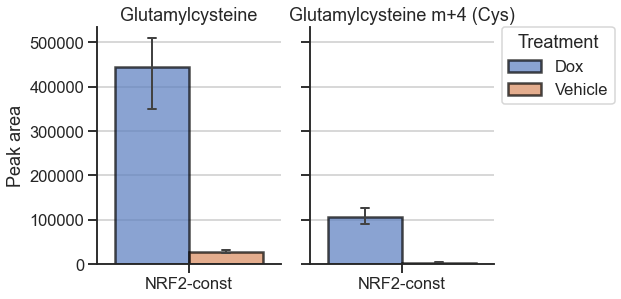

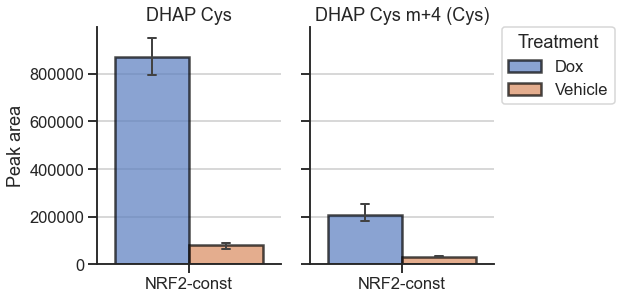

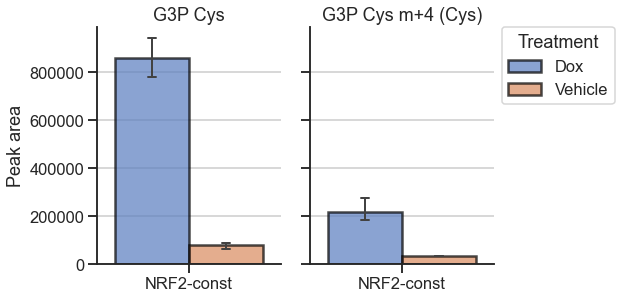

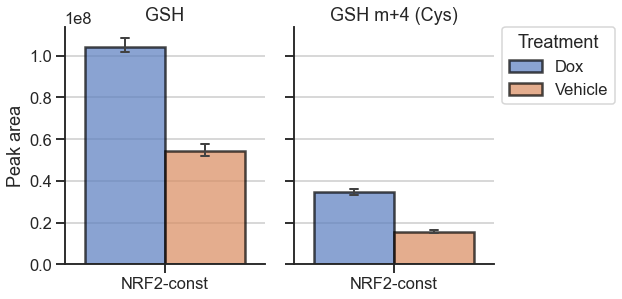

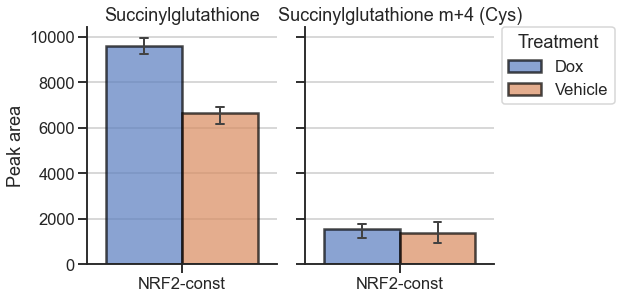

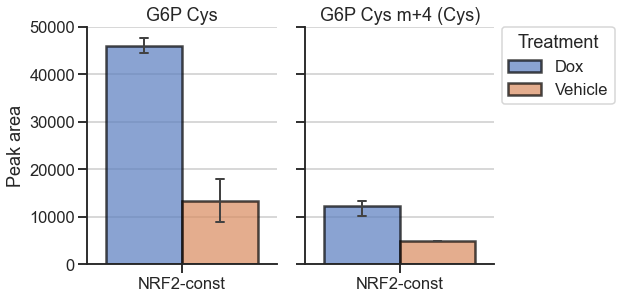

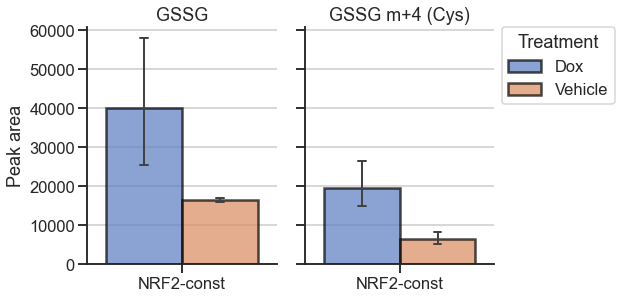

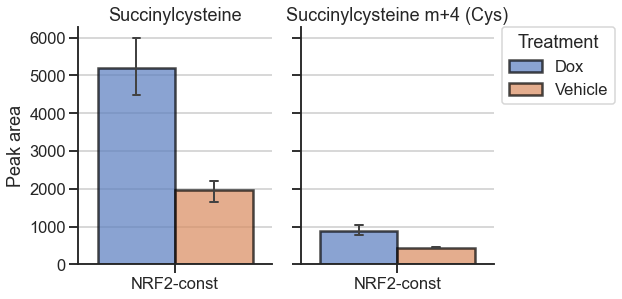

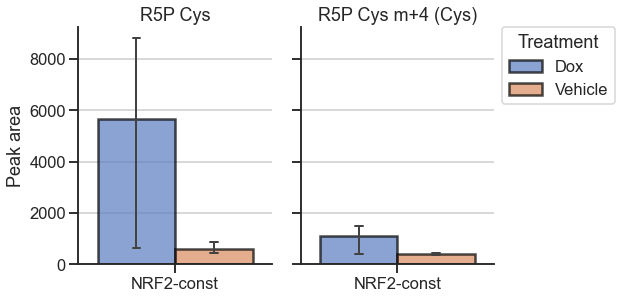

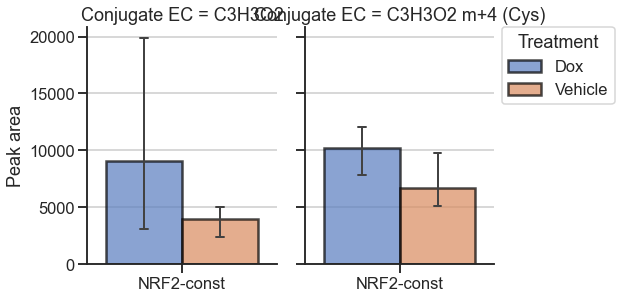

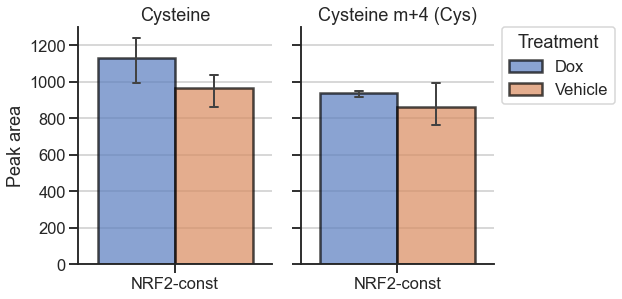

In [19]:
# Plotting, H1299 NRF2 constitutive (positive polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/pos/plots/H1299-NRF2-constitutive'
exclusion_set = {'307.08318_9.584_GSH', '307.08367_11.123_GSH', '307.08367_11.856_GSH', '178.04111_6.946_Cysteinylglycine', '178.04115_9.925_Cysteinylglycine'}
for peak_id in set(df_pos_flat[~df_pos_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)

    ### No label:
    mask = (df_pos_flat['MW_RT_anno'] == peak_id) & (df_pos_flat['Cell_line'] == 'NRF2-const')
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Cell_line', hue='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name)
    g1.grid(True, axis='y')
    g1.legend_.remove()

    ### Cysteine label (m+4):
    mask = (df_pos_flat_m4['MW_RT_anno'] == peak_id) & (df_pos_flat_m4['Cell_line'] == 'NRF2-const')
    g2 = sns.barplot(ax=ax2, data=df_pos_flat_m4[mask], y='area', x='Cell_line', hue='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name))
    g2.grid(True, axis='y')
    g2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Treatment', loc='upper left')
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_NRF2-const.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

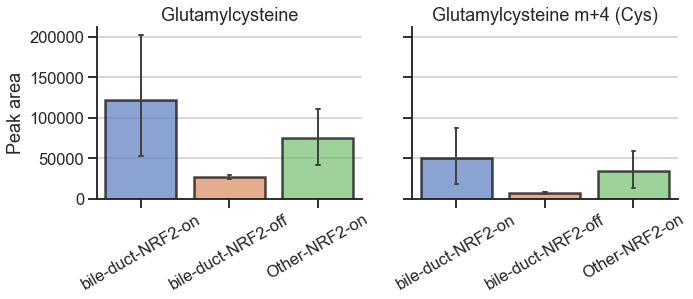

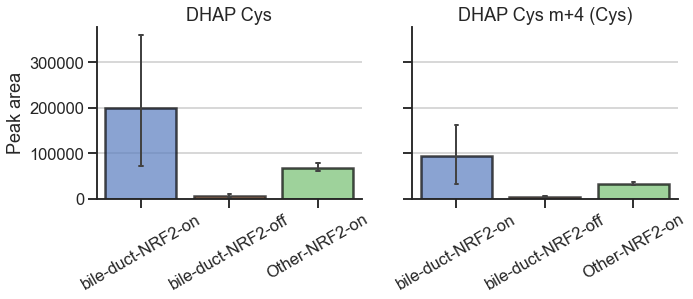

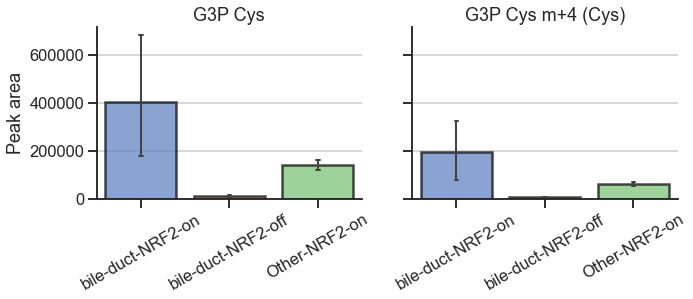

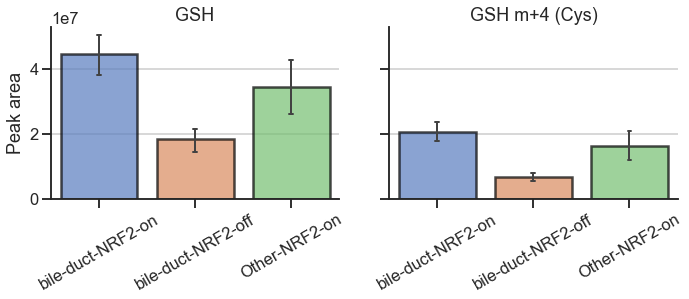

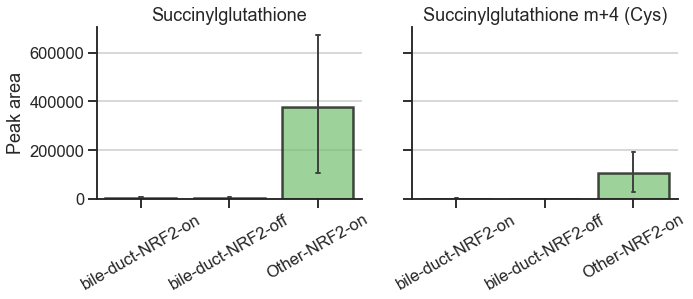

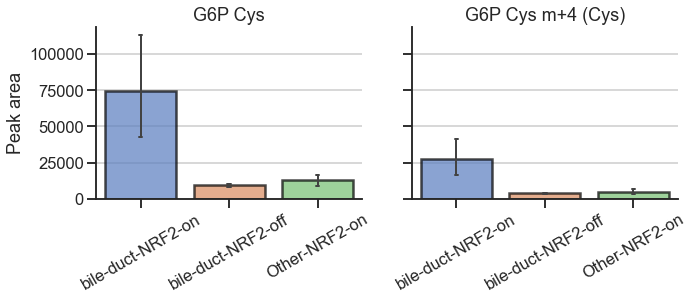

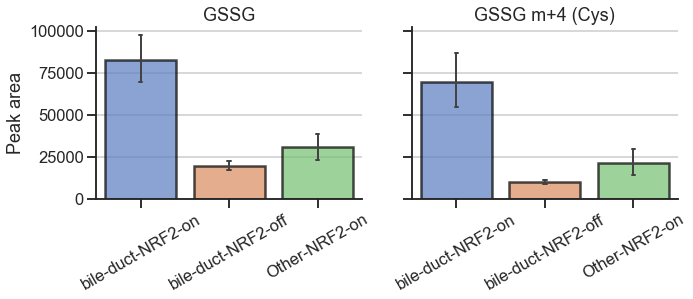

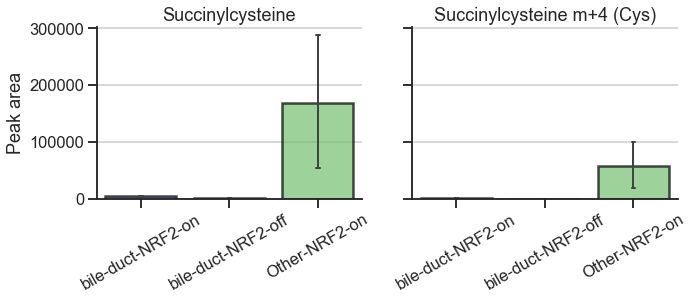

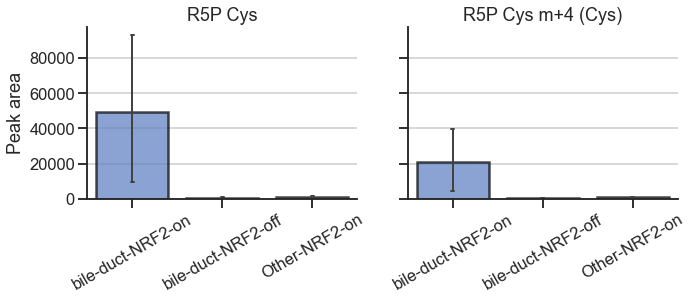

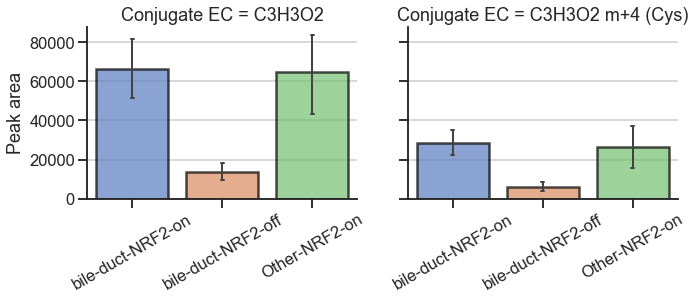

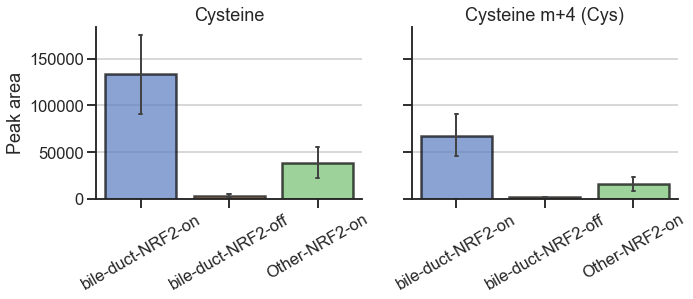

In [20]:
# Plotting, bile duct cells comparison (positive polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/pos/plots/bile-duct-comparison'
exclusion_set = {'307.08318_9.584_GSH', '307.08367_11.123_GSH', '307.08367_11.856_GSH', '178.04111_6.946_Cysteinylglycine', '178.04115_9.925_Cysteinylglycine'}
for peak_id in set(df_pos_flat[~df_pos_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)
    
    ### No label:
    mask = (df_pos_flat['MW_RT_anno'] == peak_id) & (df_pos_flat['Cell_line'] != 'NRF2-const') & ((df_pos_flat['Genotype'] == 'bile-duct-NRF2-on') | (df_pos_flat['Genotype'] == 'bile-duct-NRF2-off') | (df_pos_flat['Genotype'] == 'Other-NRF2-on'))
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)

    ### Cysteine label (m+4):
    mask = (df_pos_flat_m4['MW_RT_anno'] == peak_id) & (df_pos_flat_m4['Cell_line'] != 'NRF2-const') & ((df_pos_flat_m4['Genotype'] == 'bile-duct-NRF2-on') | (df_pos_flat_m4['Genotype'] == 'bile-duct-NRF2-off') | (df_pos_flat_m4['Genotype'] == 'Other-NRF2-on'))
    g2 = sns.barplot(ax=ax2, data=df_pos_flat_m4[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name))
    g2.grid(True, axis='y')
    g2.set_xticklabels(g2.get_xticklabels(), rotation=30)
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

In [21]:
### Get plotting data in negative polarity ###
# Data, no label:
df_neg = peak_obj.label_pairs['cys']['neg']['peak_pair_area_parent'].copy()
mask = (df_neg['Isotopes'].isnull() & df_neg['Adducts'].isnull() & df_neg['Blacklist'].isnull()) | ~df_neg['known_anno'].isnull()
df_neg, df_neg_flat = flat_df(df_neg[mask], sample_info_df)

# Data, cysteine label (m+4):
df_neg_m4 = peak_obj.label_pairs['cys']['neg']['peak_pair_area_heavy'].copy()
mask = (df_neg_m4['Isotopes'].isnull() & df_neg_m4['Adducts'].isnull() & df_neg_m4['Blacklist'].isnull()) | ~df_neg_m4['known_anno'].isnull()
df_neg_m4, df_neg_flat_m4 = flat_df(df_neg_m4[mask], sample_info_df)

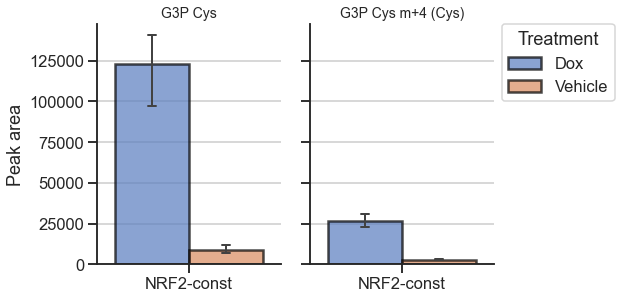

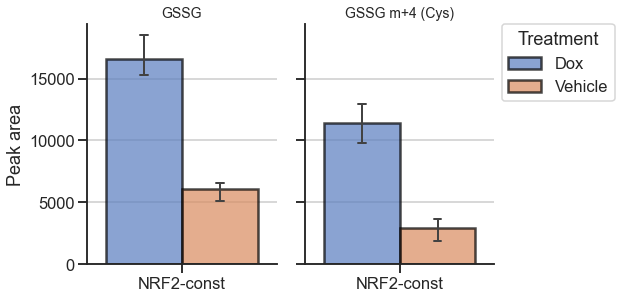

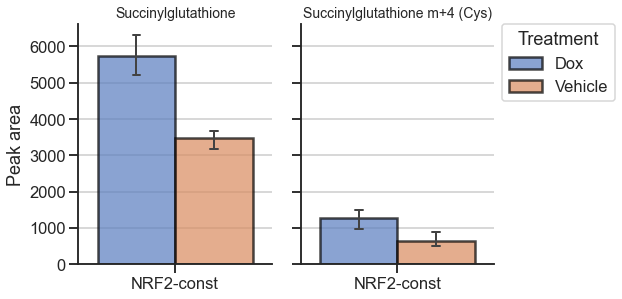

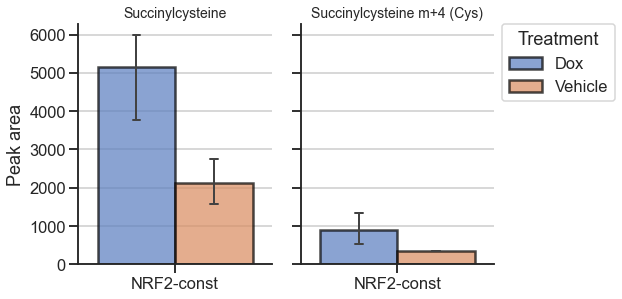

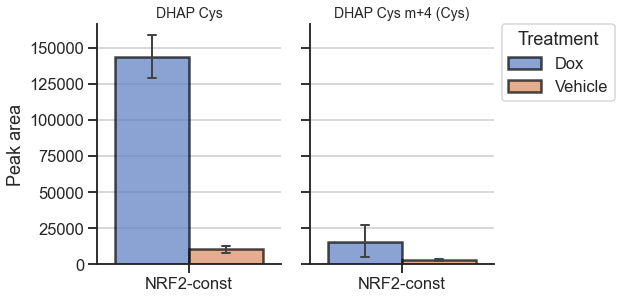

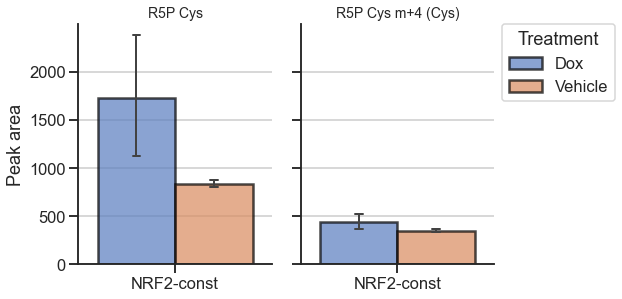

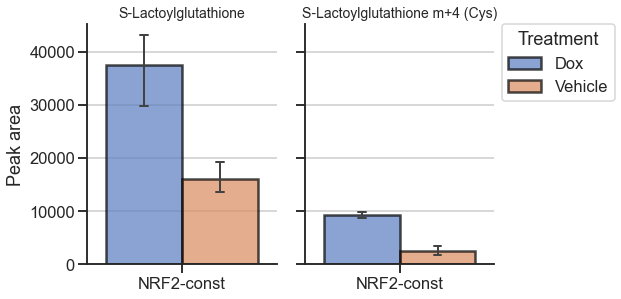

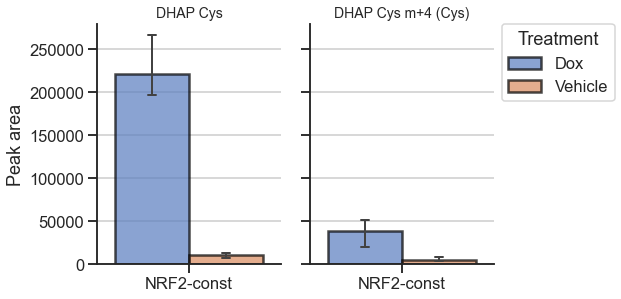

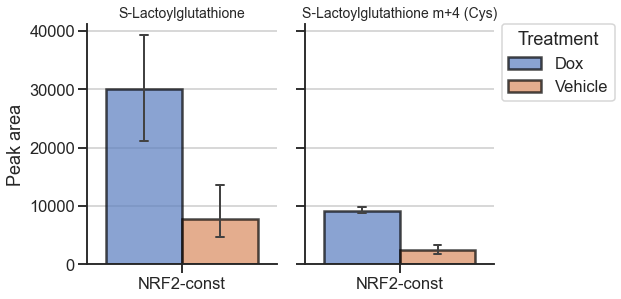

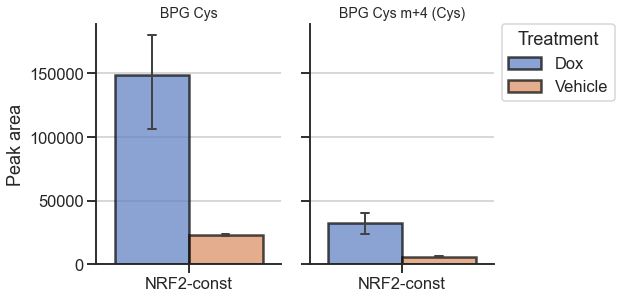

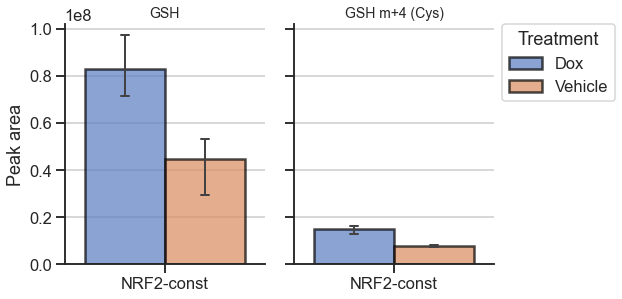

In [22]:
# Plotting, H1299 NRF2 constitutive (negative polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/neg/plots/H1299-NRF2-constitutive'
exclusion_set = {'307.08351_12.044_GSH', '307.08361_10.781_GSH', '307.0835_11.202_GSH', '307.08342_11.437_GSH', '307.08351_8.896_GSH', '307.08328_11.055_GSH', '307.08349_11.838_GSH', '307.08357_11.737_GSH', '307.08357_11.608_GSH', '307.08358_8.71_GSH', '616.15884_11.842_GSSG', '612.15131_12.119_GSSG', '178.04106_7.01_Cysteinylglycine', '178.04108_9.897_Cysteinylglycine', '612.1518_11.807_GSSG', '250.06206_9.745_Glutamylcysteine', '191.0251_10.351_Conjugate EC = C3H3O2'}
for peak_id in set(df_neg_flat[~df_neg_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)

    ### No label:
    mask = (df_neg_flat['MW_RT_anno'] == peak_id) & (df_neg_flat['Cell_line'] == 'NRF2-const')
    g1 = sns.barplot(ax=ax1, data=df_neg_flat[mask], y='area', x='Cell_line', hue='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.legend_.remove()

    ### Cysteine label (m+4):
    mask = (df_neg_flat_m4['MW_RT_anno'] == peak_id) & (df_neg_flat_m4['Cell_line'] == 'NRF2-const')
    g2 = sns.barplot(ax=ax2, data=df_neg_flat_m4[mask], y='area', x='Cell_line', hue='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name), size=14)
    g2.grid(True, axis='y')
    g2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Treatment', loc='upper left')
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_NRF2-const.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

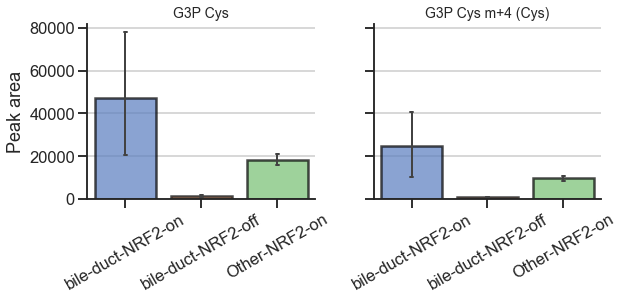

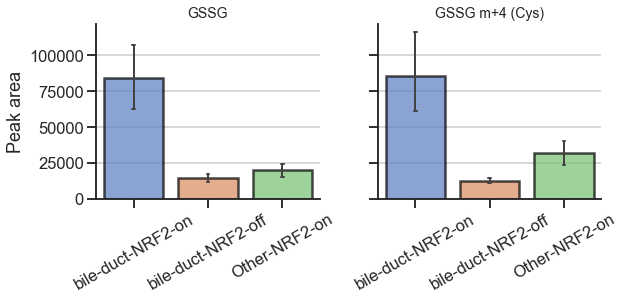

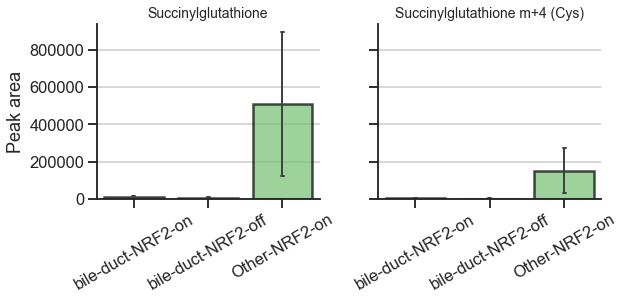

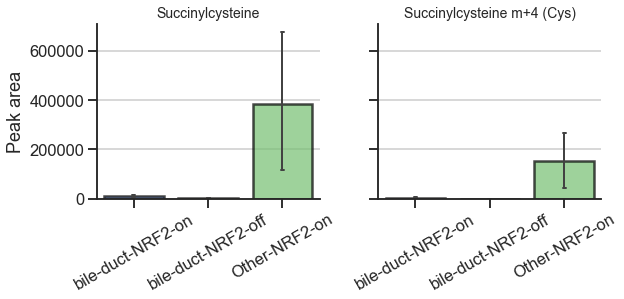

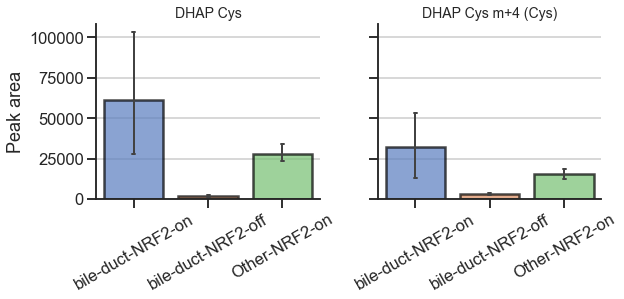

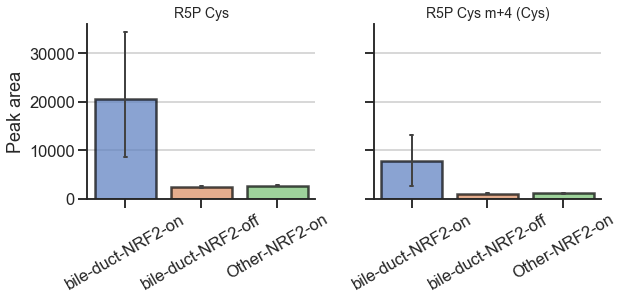

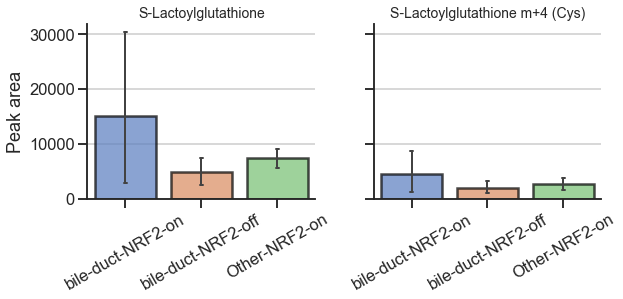

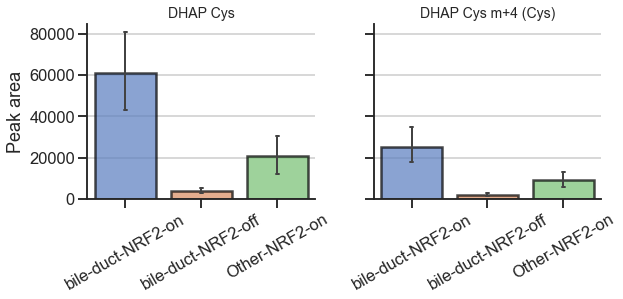

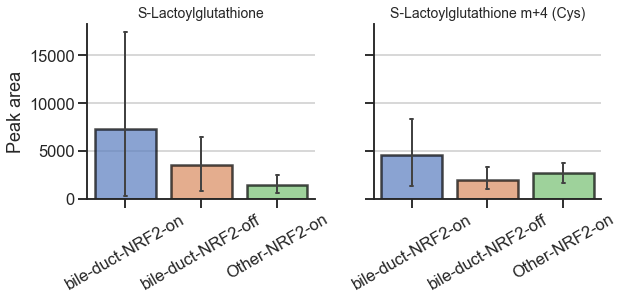

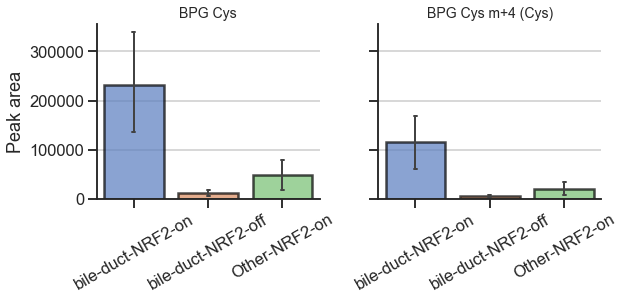

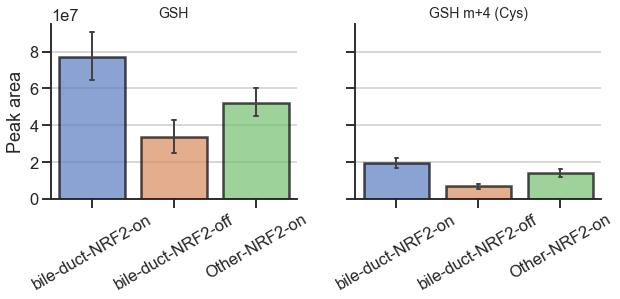

In [23]:
# Plotting, bile duct cells comparison (negative polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/neg/plots/bile-duct-comparison'
exclusion_set = {'307.08351_12.044_GSH', '307.08361_10.781_GSH', '307.0835_11.202_GSH', '307.08342_11.437_GSH', '307.08351_8.896_GSH', '307.08328_11.055_GSH', '307.08349_11.838_GSH', '307.08357_11.737_GSH', '307.08357_11.608_GSH', '307.08358_8.71_GSH', '616.15884_11.842_GSSG', '612.15131_12.119_GSSG', '178.04106_7.01_Cysteinylglycine', '178.04108_9.897_Cysteinylglycine', '612.1518_11.807_GSSG', '250.06206_9.745_Glutamylcysteine', '191.0251_10.351_Conjugate EC = C3H3O2'}
for peak_id in set(df_neg_flat[~df_neg_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)

    ### No label:
    mask = (df_neg_flat['MW_RT_anno'] == peak_id) & (df_neg_flat['Cell_line'] != 'NRF2-const') & ((df_neg_flat['Genotype'] == 'bile-duct-NRF2-on') | (df_neg_flat['Genotype'] == 'bile-duct-NRF2-off') | (df_neg_flat['Genotype'] == 'Other-NRF2-on'))
    g1 = sns.barplot(ax=ax1, data=df_neg_flat[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)

    ### Cysteine label (m+4):
    mask = (df_neg_flat_m4['MW_RT_anno'] == peak_id) & (df_neg_flat_m4['Cell_line'] != 'NRF2-const') & ((df_neg_flat_m4['Genotype'] == 'bile-duct-NRF2-on') | (df_neg_flat_m4['Genotype'] == 'bile-duct-NRF2-off') | (df_neg_flat_m4['Genotype'] == 'Other-NRF2-on'))
    g2 = sns.barplot(ax=ax2, data=df_neg_flat_m4[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name), size=14)
    g2.grid(True, axis='y')
    g2.set_xticklabels(g2.get_xticklabels(), rotation=30)
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

In [24]:
### Get plotting data in positive polarity ###
# Select peak pairs with more than 3 fold decrease after 24h 13C glucose labelling:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
t0 = df_pos.loc[:, ['SSP25_13C-Glc_0m_1', 'SSP25_13C-Glc_0m_2', 'SSP25_13C-Glc_0m_3']].sum(1)
t24 = df_pos.loc[:, ['SSP25_13C-Glc_24h_1', 'SSP25_13C-Glc_24h_2', 'SSP25_13C-Glc_24h_3']].sum(1)

mask = (t0/t24 > 3)
mask &= (df_pos['Isotopes'].isnull() & df_pos['Adducts'].isnull() & df_pos['Blacklist'].isnull()) | ~df_pos['known_anno'].isnull()
df_pos, df_pos_flat = flat_df(df_pos[mask], sample_info_df)

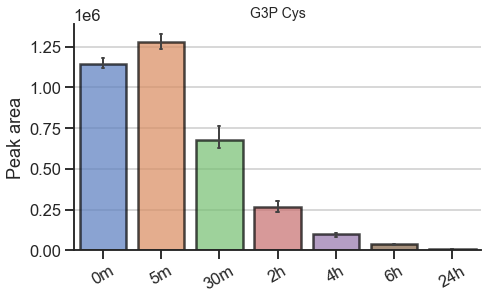

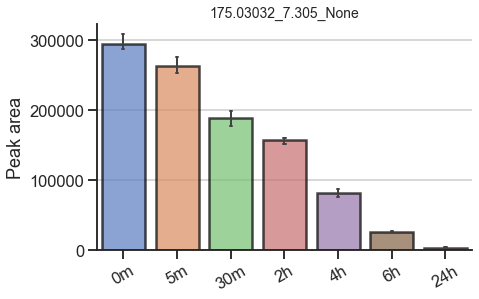

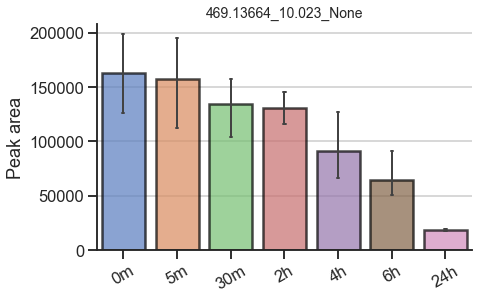

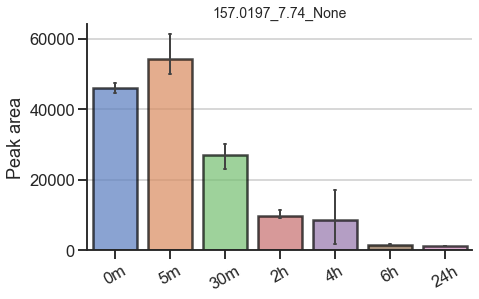

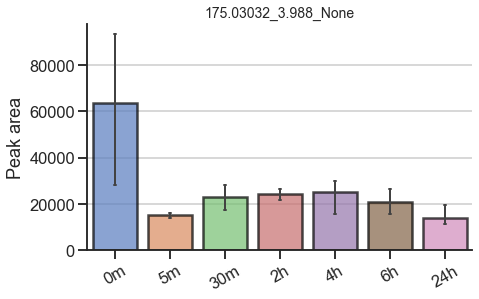

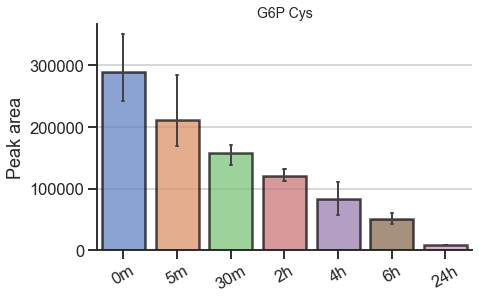

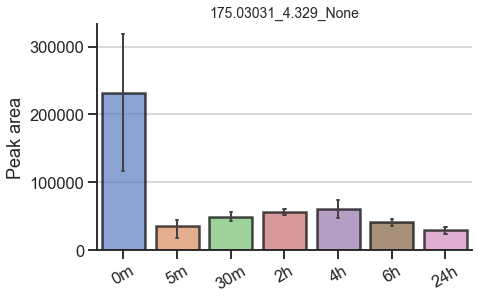

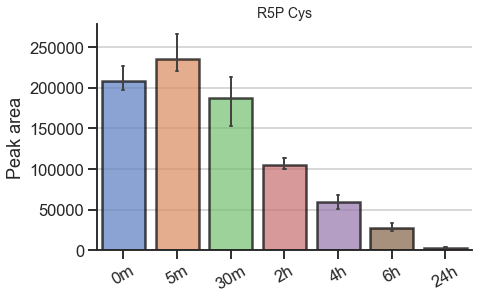

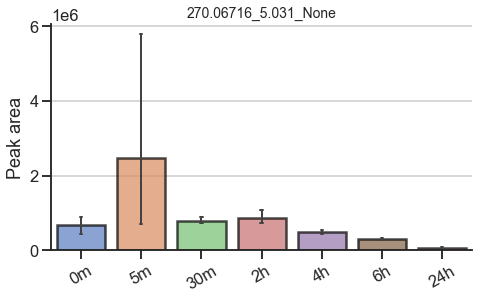

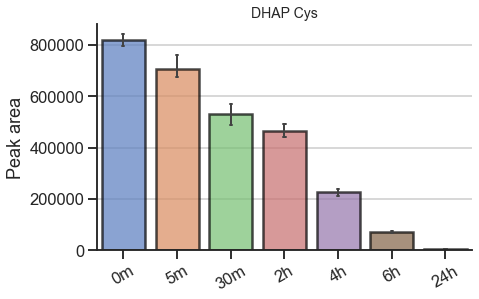

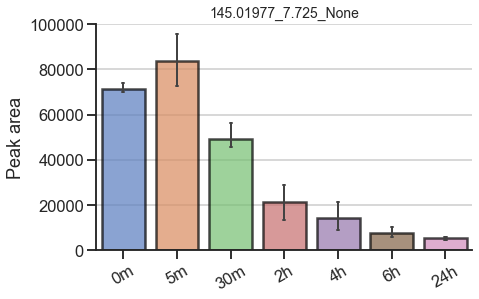

In [25]:
# Plotting, bile duct cells comparison (positive polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/pos/plots/SSP25_13C-Glc'
exclusion_set = {}
for peak_id in set(df_pos_flat['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    if name == 'None':
        name = peak_id
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 4.5))

    mask = (df_pos_flat['MW_RT_anno'] == peak_id) & (df_pos_flat['Cell_line'] == 'SSP25') & ~(df_pos_flat['Genotype'] == 'bile-duct-NRF2-on')
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)

    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

In [26]:
### Get plotting data in negative polarity ###
# Select peak pairs with more than 3 fold decrease after 24h 13C glucose labelling:
df_neg = peak_obj.label_pairs['cys']['neg']['peak_pair_area_parent'].copy()
t0 = df_neg.loc[:, ['SSP25_13C-Glc_0m_1', 'SSP25_13C-Glc_0m_2', 'SSP25_13C-Glc_0m_3']].sum(1)
t24 = df_neg.loc[:, ['SSP25_13C-Glc_24h_1', 'SSP25_13C-Glc_24h_2', 'SSP25_13C-Glc_24h_3']].sum(1)

mask = (t0/t24 > 3)
mask &= (df_neg['Isotopes'].isnull() & df_neg['Adducts'].isnull() & df_neg['Blacklist'].isnull()) | ~df_neg['known_anno'].isnull()
df_neg, df_neg_flat = flat_df(df_neg[mask], sample_info_df)

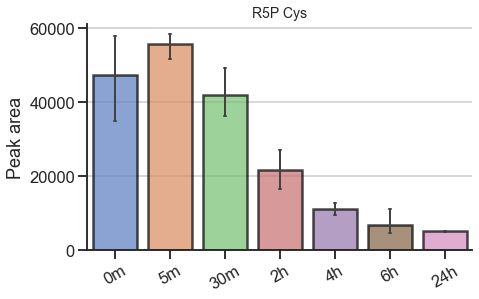

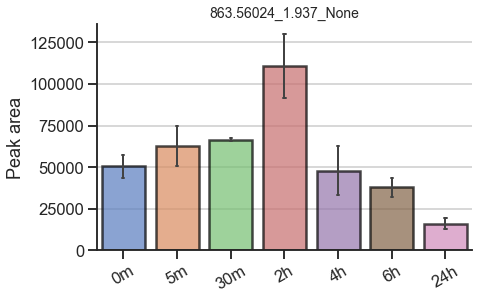

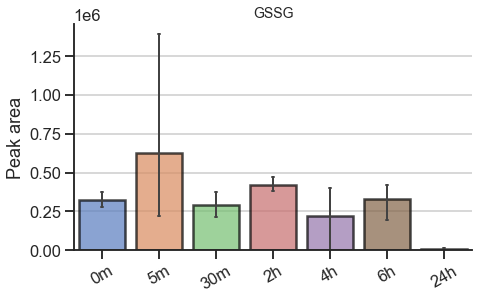

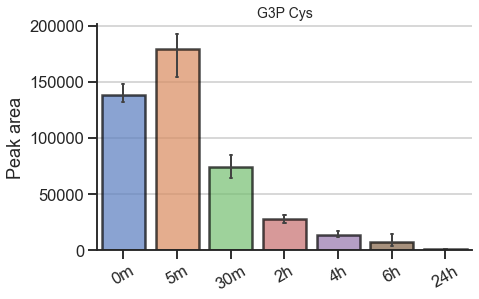

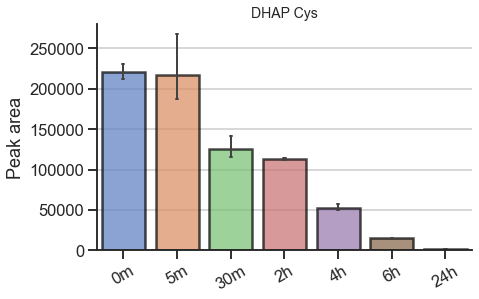

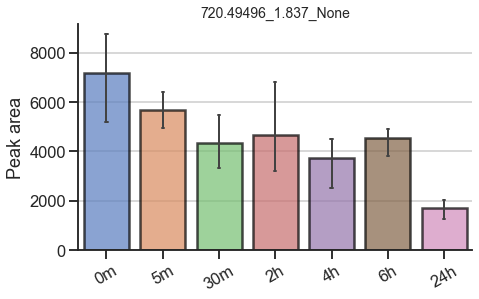

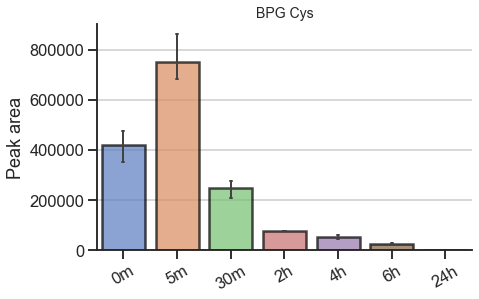

In [27]:
# Plotting, bile duct cells comparison (negative polarity):
plot_fld = 'projects/bile-duct-cells_cys-tracing/neg/plots/SSP25_13C-Glc'
exclusion_set = {}
for peak_id in set(df_neg_flat['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    if name == 'None':
        name = peak_id
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 4.5))

    mask = (df_neg_flat['MW_RT_anno'] == peak_id) & (df_neg_flat['Cell_line'] == 'SSP25') & ~(df_neg_flat['Genotype'] == 'bile-duct-NRF2-on')
    g1 = sns.barplot(ax=ax1, data=df_neg_flat[mask], y='area', x='Genotype', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)

    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig